# Luồng ảnh

# Import Packages

<ol>
  <li>Ảnh được chuyển thành base 64</li>
  <li>Từ base64 chuyển thành cv_image (BGR)</li>
  <li>Trước khi qua alignment model sẽ được chuyển thành RGB (cv2)</li>
  <li>Binary classifier nhận vào RGB (cv2)</li>
  <li>Binary nhận vào RGB (cv2)</lai>
  <li>Enhance text convert BGR thành gray (lúc nhận vào) (cv2)</li>
  <li>Enhance text convert gray thành RGB (lúc trả về) (cv2)</li>
  <li>img2text_ocr sẽ convert cv2 thành pillow image để đưa vào VietOCR</li>
</ol>

In [1]:
# !pip install vietocr==0.3.2

In [2]:
import time
import imutils
import cv2
import torch
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import base64
from io import BytesIO
import os
from tensorflow import keras
import yaml
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

import os
import base64
from io import BytesIO
from PIL import Image
import numpy as np
from mimetypes import guess_extension, guess_type
import matplotlib.pyplot as plt

2022-06-08 10:08:26.797217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-08 10:08:26.797280: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
MIN_SUBMIT_IMG_SIZE = 50
VALID_IMG_FORMAT = ["jpg", "jpeg", "png", "gif", "webp", "bmp"]
VALID_IMG_TYPE = ['image/jpeg', 'image/png', 'image/gif', 'image/webp', 'image/jpg']

def convert_cv_image_to_base64(img, imread=False, ext="jpeg"):
    if ext.lower() not in VALID_IMG_FORMAT:
        return None

    try:
        if imread == True:
            img = cv2.imread(img)
           
        _, im_arr = cv2.imencode(".{0}".format(ext.lower()), img)
        im_bytes = im_arr.tobytes()
        im_b64 = base64.b64encode(im_bytes)
        return "data:image/{0};base64,{1}".format(ext.lower(), im_b64.decode("utf-8"))
    except Exception as e:
        print(e)
    
    return None

def convert_pil_image_to_base64(img, imread=False, ext="jpeg"):
    if ext.lower() not in VALID_IMG_FORMAT:
        return None

    try:
        if imread == True:
            img = Image.open(img)

        im_file = BytesIO()
        img.save(im_file, format=("{0}".format(ext.upper())))
        im_bytes = im_file.getvalue()
        im_b64 = base64.b64encode(im_bytes)
        return "data:image/{0};base64,{1}".format(ext.lower(), im_b64.decode("utf-8"))
    except:
        pass
    
    return None

def convert_base64_to_pil_image(im_b64):
    if check_valid_image(im_b64) == False:
        return None

    arr_im_b64 = im_b64.split(",")
    if len(arr_im_b64) < 1:
        return None

    try:
        im_bytes = base64.b64decode(arr_im_b64[1])
        im_file = BytesIO(im_bytes)
        img = Image.open(im_file)
        
        width, height = img.size
        if (width < MIN_SUBMIT_IMG_SIZE) or (height < MIN_SUBMIT_IMG_SIZE):
            return None
        return img
    except:
        pass
    
    return None

def convert_base64_to_cv_image(im_b64):
    if check_valid_image(im_b64) == False:
        return None

    arr_im_b64 = im_b64.split(",")
    if len(arr_im_b64) < 1:
        return None

    try:
        im_bytes = base64.b64decode(arr_im_b64[1])
        im_arr = np.frombuffer(im_bytes, dtype=np.uint8)
        img = cv2.imdecode(im_arr, flags=cv2.IMREAD_COLOR)
        
        (height, width, _channel) = img.shape
        if (width < MIN_SUBMIT_IMG_SIZE) or (height < MIN_SUBMIT_IMG_SIZE):
            return None
        return img
    except:
        pass
    
    return None

def convert_cv2_img_to_pil_img(img, channel="RGB"):
    try:
        img = Image.fromarray(img, channel)
        return img
    except:
        return None
    
def check_valid_image(img):
    """
    img: imgbase64, filename, path or URL
    """
    try:
        ext = guess_extension(guess_type(img)[0])
        if ext is None:
            return False
        ext = ext.strip()
        if len(ext) == 0:
            return False
        ext = ext.replace(".", "")
        if ext.lower() in VALID_IMG_FORMAT:
            return True
    except:
        pass
    
    return False

In [4]:
INVALID_PARAM_MSG = "Invalid parameters"

def exist_file(file_path):
    return os.path.isfile(file_path)

def read_yolo5(path, device_type='cpu'):
    if exist_file(path) == False:
        raise Exception(INVALID_PARAM_MSG)
#     model = torch.hub.load('ultralytics/yolov5', 'custom', path=path,device=device_type)
    model = torch.hub.load('/home/jovyan/work/yolov5', 'custom', source='local', path=path,device=device_type)
    return model

In [5]:
def detect_corner(predictions_align_df):
    predictions_align_df["sum"] = predictions_align_df["xmin"] + predictions_align_df["ymin"]
    index_ = predictions_align_df["sum"].idxmax()
    if index_== 0:
        top_right = (predictions_align_df.xmax[0],predictions_align_df.ymax[0])
        bot_right = (predictions_align_df.xmin[2],predictions_align_df.ymax[2]) 
        bot_left = (predictions_align_df.xmin[3],predictions_align_df.ymin[3]) 
        top_left = (predictions_align_df.xmax[1],predictions_align_df.ymin[1]) 
    elif index_ == 1:
        top_left = (predictions_align_df.xmax[1],predictions_align_df.ymax[1])
        top_right = (predictions_align_df.xmin[0],predictions_align_df.ymax[0]) 
        bot_right = (predictions_align_df.xmin[2],predictions_align_df.ymin[2]) 
        bot_left = (predictions_align_df.xmax[3],predictions_align_df.ymin[3]) 
    elif index_ == 3:
        bot_left = (predictions_align_df.xmax[3],predictions_align_df.ymax[3])
        top_left = (predictions_align_df.xmin[1],predictions_align_df.ymax[1]) 
        top_right = (predictions_align_df.xmin[0],predictions_align_df.ymin[0]) 
        bot_right = (predictions_align_df.xmax[2],predictions_align_df.ymin[2]) 
    else:
        bot_right = (predictions_align_df.xmax[2],predictions_align_df.ymax[2])
        bot_left = (predictions_align_df.xmin[3],predictions_align_df.ymax[3]) 
        top_left = (predictions_align_df.xmin[1],predictions_align_df.ymin[1]) 
        top_right = (predictions_align_df.xmax[0],predictions_align_df.ymin[0])    
    arr_corner = np.float32([
        top_left, top_right , bot_right, bot_left
    ]) 
    return arr_corner

In [6]:
def perspective_transform(image, source_points):
    dest_points = np.float32([[0,0], [640,0], [640,480], [0,480]])
    M = cv2.getPerspectiveTransform(source_points, dest_points)
    dst = cv2.warpPerspective(image, M, (640, 480))
    return dst

## Input ảnh ở đây

In [7]:
img_path = "/data_science/data_science/data/v1/idcard/bug/image_2022-05-25_09-48-02.png"
# img_path = "/data_science/data_science/data/v1/idcard/bug/photo_2022-06-02_10-53-03.jpg"
img_base64 = convert_cv_image_to_base64(img_path, True)
img_base64

''

# Align idcard

In [8]:
align_model_path = "/data_science/data_science/data/v1/final_models/id_card/align_idcard.pt"
align_model = read_yolo5(align_model_path)

YOLOv5 🚀 v6.1-235-g632559b Python-3.9.5 torch-1.11.0+cu102 CPU

Fusing layers... 
[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.
Model summary: 367 layers, 46124433 parameters, 0 gradients
Adding AutoShape... 


In [9]:
def align_idcard(cv_img):
    cv_img = cv2.resize(cv_img,(640,640))
    
    predictions_align =  align_model(cv_img)
    predictions_align_df = predictions_align.pandas().xyxy[0]
    if len(predictions_align_df) == 4:
        predictions_align_df.sort_values(["class","confidence"],inplace=True,ascending = False)
        predictions_align_df.drop_duplicates("class",inplace=True)
        predictions_align_df.reset_index(drop=True,inplace=True)

        arr_corner = detect_corner(predictions_align_df)
        cv_img = perspective_transform(cv_img, arr_corner)

    cv_img = cv2.resize(cv_img,(640, 480))
    
    return cv_img

cv_img = convert_base64_to_cv_image(img_base64)
cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
align_img = align_idcard(cv_img)

In [10]:
# displaying image
%matplotlib inline

plt.imshow(align_img)
plt.show()

# Binary classification idcard

In [11]:
def load_model_keras(model_path):
    return keras.models.load_model(model_path)
binary_model_path = "/data_science/data_science/data/v1/final_models/id_card/binary_idcard.h5"
binary_model = load_model_keras(binary_model_path)

2022-06-08 10:08:33.694912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-08 10:08:33.694981: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-08 10:08:33.695024: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bea5eea88813): /proc/driver/nvidia/version does not exist


In [12]:
BINARY_SIZE = (224,224)
def id_binary_classification(cv_img, model):
    dim_binary = BINARY_SIZE
    #cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    cv_img=cv2.resize(cv_img, dim_binary, interpolation = cv2.INTER_AREA)
    np_img = np.asarray(cv_img)
    np_img = np_img*(1./255)
    X = np.expand_dims(np_img,axis=0)
    result = model.predict(X)
    # binary model will always return 1 (cmnd) or 0(cccd)
    return np.round(result)
        
check_cmnd = id_binary_classification(align_img,binary_model)
check_cmnd

1/1 [==============================] - 0s 190ms/step


array([[          0]], dtype=float32)

# Detect information (avatar, name, address,...)

In [13]:
detect_frontside_model_path = "/data_science/data_science/data/v1/final_models/id_card/detect_frontside_idcard.pt"
detect_frontside_new_model_path = "/data_science/data_science/data/v1/final_models/id_card/detect_frontside_idcard_new.pt"
frontside_model = read_yolo5(detect_frontside_model_path)
frontside_model_new = read_yolo5(detect_frontside_new_model_path)

YOLOv5 🚀 v6.1-235-g632559b Python-3.9.5 torch-1.11.0+cu102 CPU

Fusing layers... 
custom_YOLOv5m summary: 308 layers, 21069966 parameters, 0 gradients
Adding AutoShape... 
YOLOv5 🚀 v6.1-235-g632559b Python-3.9.5 torch-1.11.0+cu102 CPU

Fusing layers... 
YOLOv5m summary: 290 layers, 20889303 parameters, 0 gradients
Adding AutoShape... 


In [14]:
if check_cmnd == 1:
    predictions = frontside_model(align_img)
else:
    predictions = frontside_model_new(align_img)
predictions_df = predictions.pandas().xyxy[0]

In [15]:
predictions_df

xmin        ymin        xmax        ymax  confidence  class  \
0   286.074951  140.491562  554.263428  197.096573    0.895531      6   
1   371.164276  250.423431  476.974518  292.730377    0.872682      3   
2   448.543121  287.538269  542.908691  327.647156    0.856378      8   
3   282.932709  288.303894  335.915802  326.236938    0.842722      9   
4   291.867737  324.289398  539.076233  366.879852    0.814326      5   
5   356.644592  204.470749  521.346802  249.068558    0.767941      7   
6   140.442734  421.129761  228.492538  463.236938    0.727241      1   
7   368.700684  409.116333  442.534241  450.151794    0.636639      1   
8   133.920074  423.920074  229.198975  465.348480    0.566882      4   
9   319.937439  378.513855  556.323425  418.420288    0.417423      0   
10  326.028320  380.649597  550.057068  418.201904    0.260615      5   
11  370.298004  408.701782  447.467194  452.388367    0.256164      4   

           name  
0            id  
1      birthday  
2   nationality  
3           sex  
4        home_1  
5        name_1  
6     address_2  
7     address_2  
8   expiry_date  
9     address_1  
10       home_1  
11  expiry_date

In [16]:
MIN_FID_CONFIDENCE_THRESH = 0.2
idx=predictions_df.groupby(['name'])['confidence'].transform(max) == predictions_df['confidence'] #groupby + extract max confidence per class
new_predictions_df=predictions_df[idx]
fid_conf = MIN_FID_CONFIDENCE_THRESH
new_predictions_df=new_predictions_df[new_predictions_df.confidence>=fid_conf] #filter by threshold
new_predictions_df

xmin        ymin        xmax        ymax  confidence  class  \
0  286.074951  140.491562  554.263428  197.096573    0.895531      6   
1  371.164276  250.423431  476.974518  292.730377    0.872682      3   
2  448.543121  287.538269  542.908691  327.647156    0.856378      8   
3  282.932709  288.303894  335.915802  326.236938    0.842722      9   
4  291.867737  324.289398  539.076233  366.879852    0.814326      5   
5  356.644592  204.470749  521.346802  249.068558    0.767941      7   
6  140.442734  421.129761  228.492538  463.236938    0.727241      1   
8  133.920074  423.920074  229.198975  465.348480    0.566882      4   
9  319.937439  378.513855  556.323425  418.420288    0.417423      0   

          name  
0           id  
1     birthday  
2  nationality  
3          sex  
4       home_1  
5       name_1  
6    address_2  
8  expiry_date  
9    address_1

# VietOCR

In [17]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

def enhance_text(img):
    import numpy as np 
    import cv2
    import skimage.filters as filters
    # load image
    image = img
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    #gamma and equalizeHist
    #thresh = adjust_gamma(thresh,gamma=1.5)
    #thresh = cv2.equalizeHist(thresh)
    
    # Morph open to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Erode
    kernel = np.ones((1,1),np.uint8)
    opening = cv2.erode(opening,kernel,iterations = 1)
    
    # Find contours and remove small noise
    cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 5:
            cv2.drawContours(opening, [c], -1, 0, -1)

    # Invert and apply slight Gaussian blur and sharpen
    result = 255 - opening
    result = cv2.GaussianBlur(result, (3,3), 0)
    sharpen_filter = np.array([[-1,-1,-1], 
                       [-1, 9,-1],
                       [-1,-1,-1]])
    result = cv2.filter2D(result, -1, sharpen_filter)
    
    result = cv2.cvtColor(result,cv2.COLOR_GRAY2RGB)
    return result

In [18]:
def img2text_ocr(label, img, vietocr_model, new_predictions_df):
    res = (label, "")

    try:
        bbox = new_predictions_df.loc[new_predictions_df[new_predictions_df['name']==label].index]
        if bbox.empty:
            return res

        ymin = bbox.ymin
        ymax = bbox.ymax 
        xmin = bbox.xmin 
        xmax = bbox.xmax

        img = np.asarray(img)
        image_crop = img[int(ymin):int(ymax), int(xmin):int(xmax)]
        image_crop = cv2.resize(image_crop, (image_crop.shape[1],32), interpolation = cv2.INTER_AREA)
        #image_crop  = enhance_text(image_crop)
        print(image_crop.shape)
        plt.imshow(image_crop)
        plt.show()
        image_crop = convert_cv2_img_to_pil_img(image_crop)
        if image_crop != None:
            text = vietocr_model.predict(image_crop)
            res = (label, text)
    except:
        print("Loi rui")         
    return res

In [19]:
LABELS_FRONT_SIDE_ID_CARD = [
    "avatar",
    "id",
    "name_1",
    "name_2",
    "birthday",
    "sex",
    "nationality",
    "home_1",
    "home_2",
    "address_1",
    "address_2",
    "expiry_date"
]

In [20]:
weight_vietocr_path = '/data_science/data_science/data/v1/idcard/pretrained_ocr/transformerocr.pth'
#weight_vietocr_path = "/data_science/data_science/data/v1/final_models/id_card/seq2seq_ocr.pth"
config_model_vietocr_path = "/data_science/data_science/data/v1/final_models/id_card/vgg-seq2seq.yml"
config_base_vietocr_path = "/data_science/data_science/data/v1/final_models/id_card/base.yml"

In [21]:
def _load_config_from_file_vietocr(fname,fbase):
  with open(fbase, encoding='utf-8') as f:
        base_config = yaml.safe_load(f)
  with open(fname, encoding='utf-8') as f:
        config = yaml.safe_load(f)
  base_config.update(config)
  
  return Cfg(base_config)

In [22]:
def read_vietocr(weight_path, fname_path, fbase_path, device_type='cpu'):
    # config = Cfg.load_config_from_name('vgg_transformer')
    config = _load_config_from_file_vietocr(fname_path, fbase_path)
    config['weights'] = weight_path
    config['cnn']['pretrained']=False
    config['predictor']['beamsearch']=False
    config['device'] = device_type
        
    return Predictor(config)

In [23]:
vietocr_model = read_vietocr(weight_vietocr_path, config_model_vietocr_path, config_base_vietocr_path)

(32, 268, 3)


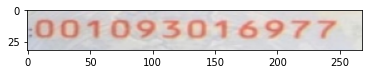

(32, 165, 3)


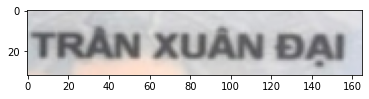

(32, 105, 3)


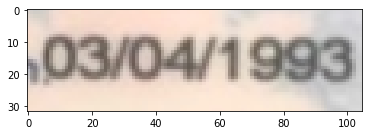

(32, 53, 3)


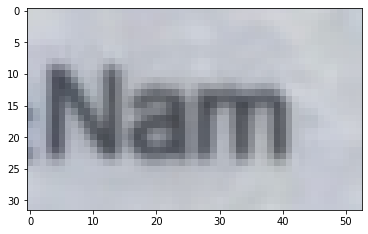

(32, 94, 3)


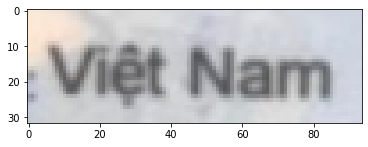

(32, 248, 3)


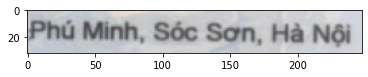

(32, 237, 3)


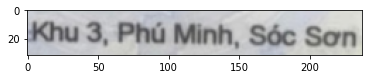

(32, 88, 3)


(32, 96, 3)


In [24]:
list_item = []
for label in LABELS_FRONT_SIDE_ID_CARD[1:]:
  item = img2text_ocr(label, align_img, vietocr_model, new_predictions_df)
  list_item.append(item)

In [25]:
list_item

[('id', '001093016977'),
 ('name_1', 'TRẦN XUÂN ĐẠI'),
 ('name_2', ''),
 ('birthday', '03/04/1993'),
 ('sex', 'Nam'),
 ('nationality', 'Việt Nam'),
 ('home_1', 'Phú Minh, Sóc Sơn, Hà Nội'),
 ('home_2', ''),
 ('address_1', 'Khu 3, Phú Minh, Sóc Sơn'),
 ('address_2', '03/04/2033'),
 ('expiry_date', '03/04/2033')]

In [26]:
# Test
# import numpy as np 
# import cv2
# import numpy as np
# import skimage.filters as filters
# # load image
# image = cv2.imread('test1.png')
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# # Morph open to remove noise
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
# opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# # Find contours and remove small noise
# cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# for c in cnts:
#     area = cv2.contourArea(c)
#     if area < 50:
#         cv2.drawContours(opening, [c], -1, 0, -1)

# # Invert and apply slight Gaussian blur
# result = 255 - opening
# result = cv2.GaussianBlur(result, (3,3), 0)
# result = cv2.cvtColor(result,cv2.COLOR_GRAY2BGR)
# sharpen_filter = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
# result = cv2.filter2D(result, -1, sharpen_filter)
# # divide gray by morphology image
# #division = cv2.divide(ress, smooth, scale=255)
# # sharpen using unsharp masking
# result = filters.unsharp_mask(result, radius=1.5, amount=2.5, multichannel=False, preserve_range=False)
# result = (255*result).clip(0,255).astype(np.uint8)
# #result = cv2.cvtColor(result,cv2.COLOR_GRAY2BGR)
# plt.imshow(result)
# plt.show()

# Avatar

In [27]:
def load_model_keras(model_path):
    return keras.models.load_model(model_path)
binary_model_path = "/data_science/data_science/data/v1/final_models/id_card/binary_idcard.h5"
binary_model = load_model_keras(binary_model_path)
BINARY_SIZE = (224,224)
def id_binary_classification(cv_img, model):
    dim_binary = BINARY_SIZE
    #cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    cv_img=cv2.resize(cv_img, dim_binary, interpolation = cv2.INTER_AREA)
    np_img = np.asarray(cv_img)
    np_img = np_img*(1./255)
    X = np.expand_dims(np_img,axis=0)
    result = model.predict(X)
    # binary model will always return 1 (cmnd) or 0(cccd)
    return np.round(result)
check_cmnd = id_binary_classification(align_img,binary_model)
check_cmnd

1/1 [==============================] - 0s 114ms/step


array([[          0]], dtype=float32)

In [28]:
detect_frontside_model_path = "/data_science/data_science/data/v1/final_models/id_card/detect_frontside_idcard.pt"
detect_frontside_new_model_path = "/data_science/data_science/data/v1/models/model_fid_ocr/model_fid_ocr/06062022_cccd_ocr.pt"
frontside_model = read_yolo5(detect_frontside_model_path)
frontside_model_new = read_yolo5(detect_frontside_new_model_path)

YOLOv5 🚀 v6.1-235-g632559b Python-3.9.5 torch-1.11.0+cu102 CPU

Fusing layers... 
custom_YOLOv5m summary: 308 layers, 21069966 parameters, 0 gradients
Adding AutoShape... 
YOLOv5 🚀 v6.1-235-g632559b Python-3.9.5 torch-1.11.0+cu102 CPU

Fusing layers... 
Model summary: 290 layers, 20889303 parameters, 0 gradients, 48.1 GFLOPs
Adding AutoShape... 


In [29]:
if check_cmnd == 1:
    predictions = frontside_model(align_img)
else:
    predictions = frontside_model_new(align_img)
predictions_df = predictions.pandas().xyxy[0]
predictions_df

xmin        ymin        xmax        ymax  confidence  class  \
0    38.213234  185.394470  202.313202  425.433105    0.912502      2   
1   369.694733  250.845840  482.210602  290.221283    0.900922      3   
2   134.501923  427.742767  231.621368  462.150177    0.893495      4   
3   349.576416  205.209274  523.762512  249.992416    0.880980      7   
4   288.155853  140.741043  543.364746  194.718094    0.866923      6   
5   450.122925  290.225708  539.619446  327.311768    0.849933      8   
6   286.429688  325.824707  542.576965  365.009399    0.849922      5   
7   282.928497  291.572113  331.610626  322.835846    0.832066      9   
8   370.681366  411.354645  446.439362  448.553131    0.724276      1   
9   318.661316  380.032654  560.432495  420.563538    0.620775      1   
10  291.461823  342.566895  551.249268  393.694641    0.328499      5   

           name  
0        avatar  
1      birthday  
2   expiry_date  
3        name_1  
4            id  
5   nationality  
6        home_1  
7           sex  
8     address_2  
9     address_2  
10       home_1

In [30]:
MIN_FID_CONFIDENCE_THRESH = 0.2
idx=predictions_df.groupby(['name'])['confidence'].transform(max) == predictions_df['confidence'] #groupby + extract max confidence per class
new_predictions_df=predictions_df[idx]
fid_conf = MIN_FID_CONFIDENCE_THRESH
new_predictions_df=new_predictions_df[new_predictions_df.confidence>=fid_conf] #filter by threshold
new_predictions_df

xmin        ymin        xmax        ymax  confidence  class  \
0   38.213234  185.394470  202.313202  425.433105    0.912502      2   
1  369.694733  250.845840  482.210602  290.221283    0.900922      3   
2  134.501923  427.742767  231.621368  462.150177    0.893495      4   
3  349.576416  205.209274  523.762512  249.992416    0.880980      7   
4  288.155853  140.741043  543.364746  194.718094    0.866923      6   
5  450.122925  290.225708  539.619446  327.311768    0.849933      8   
6  286.429688  325.824707  542.576965  365.009399    0.849922      5   
7  282.928497  291.572113  331.610626  322.835846    0.832066      9   
8  370.681366  411.354645  446.439362  448.553131    0.724276      1   

          name  
0       avatar  
1     birthday  
2  expiry_date  
3       name_1  
4           id  
5  nationality  
6       home_1  
7          sex  
8    address_2

/tmp/ipykernel_315303/3238481140.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  avatars = new_predictions_df[predictions_df.name==label].sort_values(by=['confidence'],ascending=False)


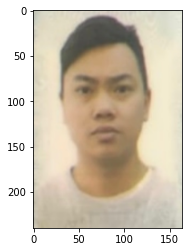

In [31]:
MIN_SUBMIT_IMG_SIZE = 50

label = 'avatar'
avatars = new_predictions_df[predictions_df.name==label].sort_values(by=['confidence'],ascending=False)
ava_conf = round(float(avatars.iloc[0]["confidence"]),2)
if ava_conf < 0.5:
    print("Error")
res = {}
if not avatars.empty:
    avatar = avatars.iloc[0]
    ymin = avatar.ymin
    ymax = avatar.ymax 
    xmin = avatar.xmin 
    xmax = avatar.xmax
    align_img = np.asarray(align_img)
    image_crop = align_img[int(ymin):int(ymax), int(xmin):int(xmax)]

    %matplotlib inline
    plt.imshow(image_crop)
    plt.show()


# Detect fingerprint

In [32]:
MAPPING_LABELS_FPRINT_ON_ID_CARD = {
    "PF Left": "left_fprint", 
    "PF Right":"right_fprint",
}
DECIMAL_NUMBER = 5

def fingerprint_extractor(label, cv_img, predictions_df):  

    bbox = predictions_df.loc[predictions_df[predictions_df['name']==label].index]
    if bbox.empty:
        return None

    xmin = bbox.xmin
    ymin = bbox.ymin
    xmax = bbox.xmax
    ymax = bbox.ymax
    image_crop = cv_img[int(ymin):int(ymax), int(xmin):int(xmax)]
    if (int(xmax) - int(xmin)) > (int(ymax) - int(ymin)):
        image_crop = cv2.rotate(image_crop, cv2.ROTATE_90_COUNTERCLOCKWISE)
    plt.imshow(image_crop)
    plt.show()
    
# classify fprint
data_path = '/data_science/data_science/data/v1/final_models/' 

fprint_model = read_yolo5("{}/id_card/detect_fprint_idcard.pt".format(data_path))

YOLOv5 🚀 v6.1-235-g632559b Python-3.9.5 torch-1.11.0+cu102 CPU

Fusing layers... 
Model summary: 367 layers, 46113663 parameters, 0 gradients
Adding AutoShape... 


In [33]:
img_path = "/data_science/data_science/data/v1/images/idcard_backside.jpg"
img_base64 = convert_cv_image_to_base64(img_path, True)
cv_img = convert_base64_to_cv_image(img_base64)
cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
cv_img = align_idcard(cv_img)

predictions = fprint_model(cv_img) # predict
predictions_df = predictions.pandas().xyxy[0]

predictions_df.sort_values(["class","confidence"],inplace=True,ascending = False)
predictions_df.drop_duplicates("class",inplace=True)
predictions_df.reset_index(drop=True,inplace=True)

  
for label in MAPPING_LABELS_FPRINT_ON_ID_CARD.keys():
    fingerprint_extractor(label=label, cv_img=cv_img, predictions_df=predictions_df)
